In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction import DictVectorizer 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_valid = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [3]:
df['duration'] = df['tpep_dropoff_datetime']-df['tpep_pickup_datetime']
df['duration'] = df['duration'].apply(lambda x: x.total_seconds()/60)

In [17]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.000,0.970,1.000,N,161,141,2,9.300,1.000,0.500,0.000,0.000,1.000,14.300,2.500,0.000,8.433
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.000,1.100,1.000,N,43,237,1,7.900,1.000,0.500,4.000,0.000,1.000,16.900,2.500,0.000,6.317
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.000,2.510,1.000,N,48,238,1,14.900,1.000,0.500,15.000,0.000,1.000,34.900,2.500,0.000,12.750
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.000,1.900,1.000,N,138,7,1,12.100,7.250,0.500,0.000,0.000,1.000,20.850,0.000,1.250,9.617
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.000,1.430,1.000,N,107,79,1,11.400,1.000,0.500,3.280,0.000,1.000,19.680,2.500,0.000,10.833


In [7]:
df['duration'].describe()

count   3009173.000
mean         14.205
std           9.939
min           1.000
25%           7.217
50%          11.550
75%          18.183
max          60.000
Name: duration, dtype: float64

In [6]:
df = df[(df.duration>=1)&(df.duration<=60)]
df.shape

(3009173, 20)

In [ ]:
categorical =['PULocationID', 'DOLocationID']
dv = DictVectorizer()
df[categorical] = df[categorical].astype('str')
train_dict = df[categorical].to_dict(orient='records')

In [9]:
X_train = dv.fit_transform(train_dict)
X_train.shape

(3009173, 515)

In [21]:
target = ['duration']
y_train = df[target].values.ravel()

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

In [22]:
print(root_mean_squared_error(y_train, y_pred, squared=False))

41.99649230697964


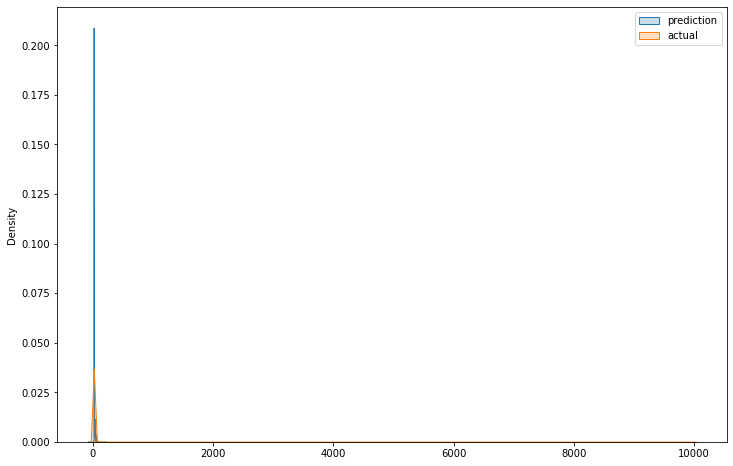

In [28]:
plt.figure(figsize=(12,8))
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_train, label='actual', fill=True)

plt.legend()
plt.show()

In [4]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime-df.tpep_pickup_datetime   
    df['duration'] = df.duration.apply(lambda x: x.total_seconds()/60)

    df = df[(df.duration>=1)&(df.duration<=60)]

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']

    df[categorical] = df[categorical].astype('str') 
    
    return df

In [5]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_valid = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [6]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dict = df_train[categorical].to_dict(orient='records')
valid_dict = df_valid[categorical].to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_valid = dv.transform(valid_dict)

In [7]:
target = ['duration']
y_train = df_train[target].values.ravel()
y_valid = df_valid[target].values.ravel()

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
y_pred_valid = lr.predict(X_valid)

In [9]:
print(mean_squared_error(y_train, y_pred, squared=False))
print(mean_squared_error(y_valid, y_pred_valid, squared=False))

7.6492610279057605
7.81183265470218


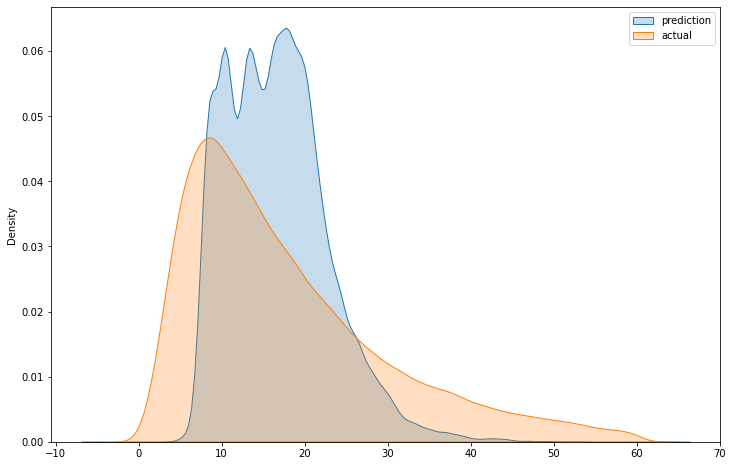

In [92]:
plt.figure(figsize=(12,8))
sns.kdeplot(y_pred_valid, label='prediction', fill=True)
sns.kdeplot(y_valid, label='actual', fill=True)

plt.legend()
plt.show()

In [82]:
ls = Lasso(alpha=0.00001)
ls.fit(X_train, y_train)

y_pred = ls.predict(X_train)

y_pred_valid = ls.predict(X_valid)

print(mean_squared_error(y_train, y_pred, squared=False))
print(mean_squared_error(y_valid, y_pred_valid, squared=False))

9.77526979809661
10.473303731022048


/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2204153.547701259, tolerance: 988.1863998081476
  model = cd_fast.sparse_enet_coordinate_descent(


In [91]:
with open('model/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv,lr), f_out)